# Visualisation of a basic Gradient Descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

When using gradient descent, we can run into some problems: 

- Getting trapped in a local minimum.

- Overshooting and missing the global optimum. This is a direct result of moving too fast along the gradient direction.

- Oscillation: This is a phenomenon that occurs when the function's value doesn't change significantly no matter the direction it advances.

To combat these problems, a momentum term $ \alpha $ is used to stabilize the rate of learning when moving towards the global optimum value.

We now define a `gradient_descent()` function. In this function, the loop ends when either:

- The number of iterations exceeds a maximum value.

- The difference in function values between two successive iterations falls below a certain threshold.

In [2]:
def gradient_descent(max_iterations, threshold, b_init,
                     obj_func, grad_func,
                     learning_rate=0.05, momentum=0.8):
    ''' 
    Input:
    - max_iterations  : Maximum number of iterations to run
    - threshold       : Stop if the difference in function values between two successive iterations falls below this threshold
    - b_init          : Initial point from where to start gradient descent
    - obj_func        : Reference to the function that computes the objective function
    - grad_func       : Reference to the function that computes the gradient of the function
    - learning_rate   : Step size for gradient descent. It should be in [0,1]
    - momentum        : Momentum to use. It should be in [0,1]
    Output:
    - b_history       : All points in space, visited by gradient descent at which the objective function was evaluated
    - f_history       : Corresponding value of the objective function computed at each point
    '''
    
    b = b_init
    b_history = b
    f_history = obj_func(b)
    delta_b = np.zeros(b.shape)
    i = 0
    diff = 1.0e10
   
    while  i<max_iterations and diff>threshold:
        delta_b = -learning_rate*grad_func(b) + momentum*delta_b
        b = b + delta_b
        
        # store the history of w and f
        b_history = np.vstack((b_history, b))
        f_history = np.vstack((f_history, obj_func(b)))
        
        # update iteration number and diff between successive values
        # of objective function
        i += 1
        diff = np.absolute(f_history[-1] - f_history[-2])
    
    return b_history, f_history

We can now run this general purpose implementation of gradient descent on one example 2D function $ f(b_1 , b_2) = b_1^2 + b_2^2$ with circular contours.

The function has a minimum value of zero at the origin. Let's visualize the function first and then find its minimum value with gradient descent.

The ```visualize_fw()``` function below, generates 2500 equally spaced points on a grid and computes the function value at each point.

The ```function_plot()``` function displays all points in different colors, depending upon the value of $f(b_1 , b_2)$
 at that point. All points at which the function's value is the same, have the same color:


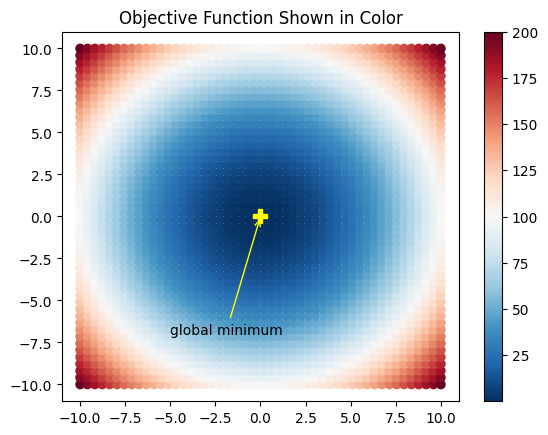

In [3]:
def visualize_fw():
    xcoord = np.linspace(-10.0, 10.0, 50)
    ycoord = np.linspace(-10.0, 10.0, 50)
    b_1, b_2 = np.meshgrid(xcoord, ycoord)
    pts = np.vstack((b_1.flatten(), b_2.flatten()))
    
    # All 2D points on the grid
    pts = pts.transpose()
    
    # Function value at each point
    f_vals = np.sum(pts*pts, axis=1)
    function_plot(pts, f_vals)
    plt.title('Objective Function Shown in Color')
    plt.show()
    return pts, f_vals

# Helper function to annotate a single point
def annotate_pt(text, xy, xytext, color):
    plt.plot(xy[0], xy[1], marker='P', markersize=10, c=color)
    plt.annotate(text, xy=xy, xytext=xytext,
                 arrowprops=dict(arrowstyle="->",
                 color=color,
                 connectionstyle='arc3'))

# Plot the function
# Pts are 2D points and f_val is the corresponding function value
def function_plot(pts, f_val):
    f_plot = plt.scatter(pts[:,0], pts[:,1],
                         c=f_val, vmin=min(f_val), vmax=max(f_val),
                         cmap='RdBu_r')
    plt.colorbar(f_plot)
    # Show the optimal point
    annotate_pt('global minimum', (0,0), (-5,-7), 'yellow')    

pts, f_vals = visualize_fw()

Now we use the gradient descent function to minimize our objective function. To call `gradient_descent()`, we define two functions:

`f()`: Computes the objective function at any point `b`

`grad()`: Computes the gradient at any point `b`

To understand the effect of various hyper-parameters on gradient descent, the function `solve_fw()` calls `gradient_descent()` with 5 iterations for different values of learning rate and momentum.


## What is Momentum?

SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum.

<img src="./images/no-momentum.gif" alt="https://mlfromscratch.com/optimizers-explained/#/" width="500"/>
<img src="./images/momentum.gif" alt="https://mlfromscratch.com/optimizers-explained/#/" width="500"/>

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in the images above. It does this by adding a fraction 
$ \gamma $ of the update vector of the past time step to the current update vector:

$$ v_{t} = \gamma v_{t-1} + \alpha \frac{\partial}{\partial b} J(b)  $$
$$  b_{t} = b_{t-1} - v_{t} $$

*Note: Some implementations exchange the signs in the equations. The momentum term $ \gamma $ is usually set to a value between 0 and 1.*

Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way (until it reaches its terminal velocity if there is air resistance, i.e. $ \gamma < 1 $. The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.


If you want to play with momentum and learning rate, I recommend visiting distill's page for [Why Momentum Really Work](https://distill.pub/2017/momentum/).



The function `visualize_learning()`, plots the values of 
$ (b_1 , b_2) $, with function values shown in different colors. The arrows in the plot make it easier to track which point was updated from the last:

In [4]:
# Objective function
def f(b, extra=[]):
    return np.sum(b*b)

# Function to compute the gradient
def grad(b, extra=[]):
    return 2*b

# Function to plot the objective function
# and learning history annotated by arrows
# to show how learning proceeded
def visualize_learning(b_history):  
    
    # Make the function plot
    function_plot(pts, f_vals)
    
    # Plot the history
    plt.plot(b_history[:,0], b_history[:,1], marker='o', c='magenta') 
    
    # Annotate the point found at last iteration
    annotate_pt('minimum found',
                (b_history[-1,0], b_history[-1,1]),
                (-1,7), 'green')
    iter = b_history.shape[0]
    for b, i in zip(b_history, range(iter-1)):
        # Annotate with arrows to show history
        plt.annotate("",
                    xy=b, xycoords='data',
                    xytext=b_history[i+1,:], textcoords='data',
                    arrowprops=dict(arrowstyle='<-',
                            connectionstyle='angle3'))     
    
def solve_fw():
    # Setting up
    rand = np.random.RandomState(19)
    b_init = rand.uniform(-10,10,2)
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(18, 12))
    learning_rates = [0.05, 0.2, 0.5, 0.8, 1]
    momentum = [0, 0.2, 0.5, 0.9]
    ind = 1
    
    # Iteration through all possible parameter combinations
    for alpha in momentum:
        for eta, col in zip(learning_rates, [0, 1, 2, 3, 4]):
            plt.subplot(4, 5, ind)        
            b_history, f_history = gradient_descent(5, -1, b_init, f, grad, eta, alpha)
            
            visualize_learning(b_history)
            ind = ind+1
            plt.text(-9, 12, 'Learning Rate = ' + str(eta), fontsize=13)
            if col==1:
                plt.text(10, 15, 'momentum = ' + str(alpha), fontsize=20)

    fig.subplots_adjust(hspace=0.5, wspace=.3)
    plt.show()

Let's run ```solve_fw()``` and see how the learning rate and momentum effect gradient descent:

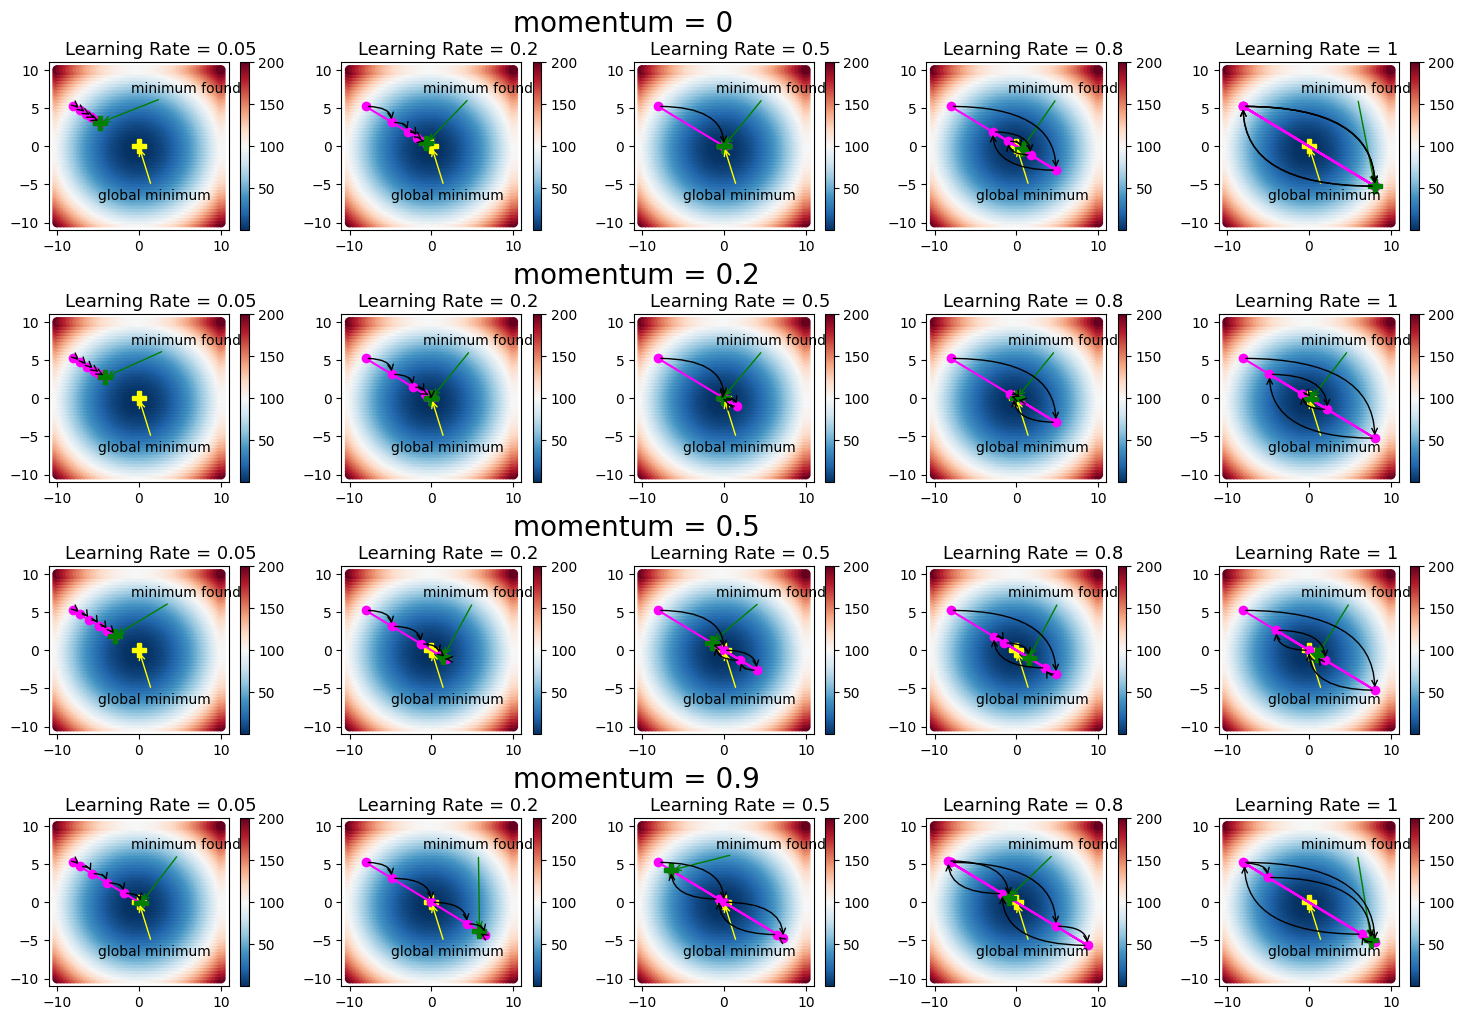

In [5]:
solve_fw()

This example clarifies the role of both momentum and learning rate.

In the first plot, with zero momentum and learning rate set at 0.05, learning is slow and the algorithm does not reach the global minimum. Increasing the momentum speeds up learning as we can see from the plots in the first column. The other extreme is the last column, where the learning rate is kept high. This causes oscillations, which can be controlled to a certain extent by adding momentum.

The general guideline for gradient descent is to use small values of learning rate and higher values of momentum.